# LightGBM 二分类

本范例演示LightGBM解决机器学习二分类问题，并使用torchkeras的VLog在训练过程中动态监控验证集AUC.

有关LightGBM算法的原理介绍，可以参考：《30分钟学会LightGBM》https://zhuanlan.zhihu.com/p/292137346


我们使用的是一个银行营销数据集：Bank_marketing_data_set_UCI。

这是一个与葡萄牙银行机构的直接营销活动相关的数据集，这些活动主要是通过电话进行的。

数据集的目标是预测客户是否会订阅银行的定期存款。

数据集有4.5W条样本，16个特征，包括类别特征和连续特征。



## 一，准备数据

In [9]:
import numpy as np
import pandas as pd
import lightgbm as lgb 
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

np.random.seed(42)


X, y = fetch_openml("Bank_marketing_data_set_UCI", 
                    version=1, as_frame=True, return_X_y=True,parser='auto')
dfdata = X.join(y)
del X, y


cat_cols = ['job', 'marital', 'education', 'default', 'housing',
       'loan', 'contact', 'day', 'month', 'campaign',
       'previous', 'poutcome']

num_cols = ['age', 'balance', 'duration', 'pdays']
target_col="y"


#将target列转换为数值
encoder  = OrdinalEncoder(handle_unknown="use_encoded_value", encoded_missing_value=np.nan, unknown_value=np.nan)
dfdata[target_col] = encoder.fit_transform(dfdata[[target_col]])


for col in  cat_cols:
    encoder  = OrdinalEncoder(handle_unknown="use_encoded_value", encoded_missing_value=np.nan, unknown_value=np.nan)
    dfdata[col] = encoder.fit_transform(dfdata[col].values.reshape(-1,1))[:,0]


dftmp, dftest = train_test_split(dfdata, stratify=dfdata["y"], test_size=0.2, random_state=42)
dftrain, dfval = train_test_split(dftmp, stratify=dftmp["y"], test_size=0.2, random_state=42)


ds_train = lgb.Dataset(dftrain[num_cols+cat_cols], label=dftrain[target_col],categorical_feature=cat_cols)
ds_val = lgb.Dataset(dfval[num_cols+cat_cols],label=dfval[target_col],categorical_feature=cat_cols)
ds_test = lgb.Dataset(dftest[num_cols+cat_cols], label=dftest[target_col],categorical_feature=cat_cols)


## 二，定义模型

In [20]:
#设计模型的参数
params = {
    'n_estimators':1000,
    'boosting_type': 'gbdt',
    'objective':'binary',
    'metric': 'auc', 
    'learning_rate': 0.01,
    'verbose': 3,
    'early_stopping_round':100
}


## 三，训练模型

In [17]:
from torchkeras import VLog 

#设计一个适配lightgbm的回调函数，动态显示训练过程指标
class VLogCallback:
    def __init__(self, num_boost_round, 
                 monitor_metric='val_loss',
                 monitor_mode='min'):
        self.order = 20
        self.num_boost_round = num_boost_round
        self.vlog = VLog(epochs = num_boost_round, monitor_metric = monitor_metric, 
                         monitor_mode = monitor_mode)

    def __call__(self, env) -> None:
        metrics = {}
        for item in env.evaluation_result_list:
            if len(item) == 4:
                data_name, eval_name, result = item[:3]
                metrics[data_name+'_'+eval_name] = result
            else:
                data_name, eval_name = item[1].split()
                res_mean = item[2]
                res_stdv = item[4]
                metrics[data_name+'_'+eval_name] = res_mean
        self.vlog.log_epoch(metrics)

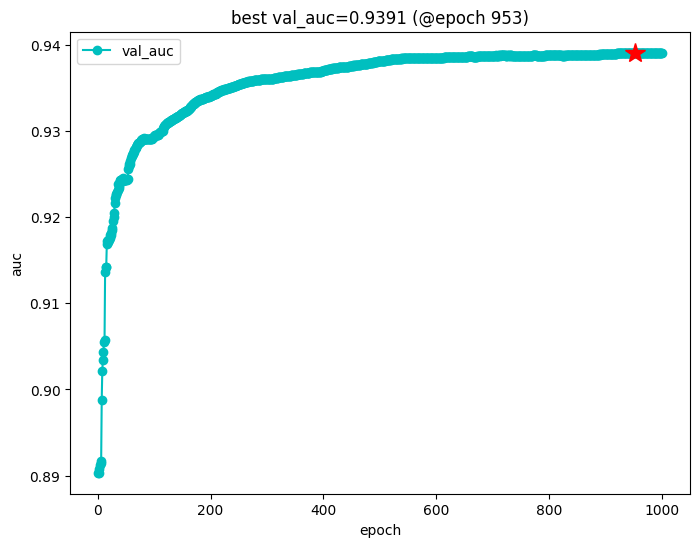

[LightGBM] [Info] Number of positive: 3385, number of negative: 25549
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.821070
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.393268
[LightGBM] [Debug] init for col-wise cost 0.001419 seconds, init for row-wise cost 0.002082 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 981
[LightGBM] [Info] Number of data points in the train set: 28934, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116990 -> initscore=-2.021244
[LightGBM] [Info] Start training from score -2.021244
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11


/Users/liangyun2/miniforge3/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug

,val_auc,epoch
0,0.890328,1
1,0.890328,2
2,0.890765,3
3,0.891202,4
4,0.891463,5
...,...,...
995,0.939025,996
996,0.939024,997
997,0.939027,998
998,0.939029,999


In [21]:
vlog_cb = VLogCallback(params['n_estimators'], monitor_metric = 'val_auc', monitor_mode = 'max')
vlog_cb.vlog.log_start()
result = {}

model = lgb.train(params, ds_train, 
        valid_sets=[ds_val], 
        valid_names=['val'],
        callbacks = [lgb.record_evaluation(result),vlog_cb]
        )

vlog_cb.vlog.log_end()

## 四，评估模型

In [35]:
from sklearn.metrics import roc_auc_score 
y_pred_val = model.predict(dfval[num_cols+cat_cols], num_iteration=model.best_iteration)
val_auc = roc_auc_score(dfval[target_col],y_pred_val) 

y_pred_test = model.predict(dftest[num_cols+cat_cols], num_iteration=model.best_iteration)
test_auc = roc_auc_score(dftest[target_col],y_pred_test) 

print('val_auc = ',val_auc)
print('test_auc = ' , test_auc)


val_auc =  0.9390840316728618
test_auc =  0.9314767883543457


In [40]:
from torchkeras.plots import plot_score_distribution,plot_importance 

dfimportance = pd.DataFrame({'feature':model.feature_name(),
  'importance':model.feature_importance(importance_type='gain')})

fig1 = plot_importance(dfimportance['feature'],dfimportance['importance'])
fig1.show()

fig2 = plot_score_distribution(dftest[target_col],y_pred_test)
fig2.show() 


## 五，使用模型

In [54]:
#预测概率
y_test = model.predict(dftest[num_cols+cat_cols], num_iteration=model.best_iteration)

#获取样本在每棵树上叶子结点的索引，可以把它们作为onehot特征喂入线性模型
y_test_leaf = model.predict(dftest[num_cols+cat_cols], pred_leaf=True, num_iteration=model.best_iteration)

## 六，保存模型

In [44]:
model.save_model("model.txt")
model_loaded = lgb.Booster(model_file='model.txt')
ypred_test = model_loaded.predict(dftest[num_cols+cat_cols], num_iteration=model_loaded.best_iteration)